In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
! pip install folium==0.5.0
import folium

     |████████████████████████████████| 112kB 18.4MB/s eta 0:00:01


# Step 1: Load the neighborhood coordinates database.

In [2]:
csv_path = 'limite-des-quartiers-de-lille-et-de-ses-communes-associees.csv'
df_Lille = pd.read_csv(csv_path, delimiter='\;')
Lille_data = df_Lille.drop(['Code_com', 'Code_quar', 'Geo Shape'], axis=1)
Lille_data = Lille_data.rename(columns={"Quartier": "Neighborhood", "Code_post": "Postal Code", "Geo Point":"Coordinates"})

csv_path = 'VilleMTP_MTP_SousQuartiers-1.csv'
df_MTP = pd.read_csv(csv_path, delimiter='\t')
MTP_data = df_MTP.drop(['AREA', 'OBJECTID', 'PERIMETER', 'SQUARTIER_', 'QUARTIER', 'SQUARTMNO', 'Shape_Leng', 'Shape_Area'], axis=1)
MTP_data = MTP_data.rename(columns={"LIBSQUART": "Neighborhood"})

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [3]:
Lille_data.head()

,Commune,Neighborhood,Postal Code,Coordinates
0,Lille,Lille-Moulins,59000,"50.6190974622,3.07017646955"
1,Lille,Faubourg de Béthune,59000,"50.6181640494,3.03328805626"
2,Lomme,Lomme,59160,"50.6424218359,2.99423836969"
3,Lille,Bois-Blancs,59000,"50.6311164029,3.02795202499"
4,Hellemmes,Hellemmes,59260,"50.6257272929,3.10971025689"


In [4]:
print(Lille_data.dtypes)

Commune         object
Neighborhood    object
Postal Code      int64
Coordinates     object
dtype: object


In [5]:
MTP_data.head()

,Neighborhood,Latitude,Longitude,Postal Code
0,Plan des 4 Seigneurs,43.6375,3.8528,34090
1,Hopitaux-Facultés,43.6329,3.8477,34090
2,Aiguelongue,43.6287,3.8831,34090
3,Les Hauts de Massane,43.6387,3.8172,34080
4,Alco,43.6235,3.8426,34080


In [6]:
lat = []
lon = []
for row in Lille_data['Coordinates']:
    try:
        lat.append(row.split(',')[0])
        lon.append(row.split(',')[1])
        
    except:
        lat.append(np.NaN)
        lon.append(np.Nan)
Lille_data['Latitude']=lat
Lille_data['Longitude']=lon
Lille_data = Lille_data.drop(['Coordinates'], axis=1)
Lille_data['Latitude'] = Lille_data['Latitude'].astype(float)
Lille_data['Longitude'] = Lille_data['Longitude'].astype(float)

Lille data was cleaned, the coordinates were split into Latitude and Longitude then converted them from object to float type so they can be read in folium map.
Montpellier was not needed because done beforehand.

In [7]:
Lille_data.head()

,Commune,Neighborhood,Postal Code,Latitude,Longitude
0,Lille,Lille-Moulins,59000,50.619097,3.070176
1,Lille,Faubourg de Béthune,59000,50.618164,3.033288
2,Lomme,Lomme,59160,50.642422,2.994238
3,Lille,Bois-Blancs,59000,50.631116,3.027952
4,Hellemmes,Hellemmes,59260,50.625727,3.109710


In [8]:
print(Lille_data.dtypes)

Commune          object
Neighborhood     object
Postal Code       int64
Latitude        float64
Longitude       float64
dtype: object


# Set up Foursquare Information

In [9]:
CLIENT_ID = 'LKUGLYOQPM0IAHR5PSONM3M520JMWGB4QGXF3AXZXWUB1YSK'
CLIENT_SECRET = 'CSJEOQYAROD2CNE4RGP4S4K1Z40JTWG4RO5BTWIRYE5IP3YV'
ACCESS_TOKEN = 'MYZALMYCUEP3YI5NWDL3MXAIXMOOUCLCVRAYXMRMVT0WQSLI'
VERSION = '20180604'
LIMIT = 100

In [10]:
address = 'Lille, Lille'
geolocator = Nominatim(user_agent="Lille_explorer")
location_Lille = geolocator.geocode(address)
latitude_Lille = location_Lille.latitude
longitude_Lille = location_Lille.longitude
print('The Coordinates of Lille are {}, {}.'.format(latitude_Lille, longitude_Lille))

The Coordinates of Lille are 50.6365654, 3.0635282.


In [11]:
address = 'Montpellier, Montpellier'
geolocator = Nominatim(user_agent="MTP_explorer")
location_MTP = geolocator.geocode(address)
latitude_MTP = location_MTP.latitude
longitude_MTP = location_MTP.longitude
print('The Coordinates of Montpellier are {}, {}.'.format(latitude_MTP, longitude_MTP))

The Coordinates of Montpellier are 43.6112422, 3.8767337.


In [12]:
print('The Lille dataframe has {} Postal Codes and {} neighborhoods.'.format(
        len(Lille_data['Postal Code'].unique()),
        Lille_data.shape[0]
    )
)
print('The Montpellier dataframe has {} Postal Codes and {} neighborhoods.'.format(
        len(MTP_data['Postal Code'].unique()),
        MTP_data.shape[0]
    )
)

The Lille dataframe has 3 Postal Codes and 12 neighborhoods.
The Montpellier dataframe has 4 Postal Codes and 31 neighborhoods.


# Neighborhood Maps of Montpellier and Lille

In [13]:
map_Montpellier = folium.Map(location=[latitude_MTP, longitude_MTP], zoom_start=12)

for lat, lng, neighborhood in zip(MTP_data['Latitude'], MTP_data['Longitude'], MTP_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Montpellier)  
    
map_Montpellier

In [14]:
map_Lille = folium.Map(location=[latitude_Lille, longitude_Lille], zoom_start=12)

for lat, lng, neighborhood in zip(Lille_data['Latitude'], Lille_data['Longitude'], Lille_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Lille)  
    
map_Lille

# Step 3: Foursquare Venue Information

We will now restrict Foursquare requests to the specific Restaurant venue type by the CategoryId.

In [15]:
CLIENT_ID = 'LKUGLYOQPM0IAHR5PSONM3M520JMWGB4QGXF3AXZXWUB1YSK' # your Foursquare ID
CLIENT_SECRET = 'CSJEOQYAROD2CNE4RGP4S4K1Z40JTWG4RO5BTWIRYE5IP3YV' # your Foursquare Secret
ACCESS_TOKEN = 'MYZALMYCUEP3YI5NWDL3MXAIXMOOUCLCVRAYXMRMVT0WQSLI' # your FourSquare Access Token
VERSION = '20180605'
LIMIT = 100
radius=1000
categoryId= '4d4b7105d754a06374d81259'

Venue request for Lille

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat_Lille, lng_Lille in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat_Lille, 
            lng_Lille,
            categoryId,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Venue request for Montpellier

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat_MTP, lng_MTP in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat_MTP, 
            lng_MTP,
            categoryId,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat_MTP, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
Lille_venues = getNearbyVenues(names=Lille_data['Neighborhood'],
                                   latitudes=Lille_data['Latitude'],
                                   longitudes=Lille_data['Longitude']
                                  )
Montpellier_venues = getNearbyVenues(names=MTP_data['Neighborhood'],
                                   latitudes=MTP_data['Latitude'],
                                   longitudes=MTP_data['Longitude']
                                  )

Lille-Moulins
Faubourg de Béthune
Lomme
Bois-Blancs
Hellemmes
Vauban-Esquermes
Saint-Maurice Pellevoisin
Lille-Centre
Wazemmes
Lille-Sud
Vieux-Lille
Fives
Plan des 4 Seigneurs
Hopitaux-Facultés
Aiguelongue
Les Hauts de Massane
Alco
Mosson
Grammont
Les Aubes
Boutonnet
Les Beaux - Arts
La Pompignane
Millénaire
Les Cevennes
Celleneuve
Les Arceaux
Centre Historique
Antigone
Comédie
La Martelle
Port Marianne
La Chamberte
Gambetta
Figuerolles
Gares
Estanove
Aiguerelles
Saint Martin
Lemasson
Pas du Loup
Croix d'Argent
Près d'Arènes


In [19]:
Lille_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lille-Moulins,50.619097,3.089985,La Consigne,50.625019,3.069697,Restaurant
1,Lille-Moulins,50.619097,3.089985,Layalina,50.624922,3.060513,Mediterranean Restaurant
2,Lille-Moulins,50.619097,3.089985,Baan Boon,50.624856,3.068454,Thai Restaurant
3,Lille-Moulins,50.619097,3.089985,Baba Yaga,50.626352,3.064073,Russian Restaurant
4,Lille-Moulins,50.619097,3.089985,Friterie Sensas,50.624517,3.068810,Friterie
5,Lille-Moulins,50.619097,3.089985,Trolls et Petits Lutins,50.626025,3.066417,Estaminet
6,Lille-Moulins,50.619097,3.089985,L'Auberge du Temps Jadis,50.625869,3.064979,French Restaurant
7,Lille-Moulins,50.619097,3.089985,Pate à sel,50.624335,3.068123,French Restaurant
8,Lille-Moulins,50.619097,3.089985,Bodrum Kebab,50.618226,3.071830,Kebab Restaurant
9,Lille-Moulins,50.619097,3.089985,La Basoche,50.619139,3.069258,Fast Food Restaurant


In [20]:
Montpellier_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Plan des 4 Seigneurs,43.6375,3.089985,Boulangerie du Plan,43.640580,3.857756,Bakery
1,Plan des 4 Seigneurs,43.6375,3.089985,Trinque Fougasse,43.640354,3.862381,French Restaurant
2,Plan des 4 Seigneurs,43.6375,3.089985,"Picadeli, bar à salades",43.629636,3.851393,Salad Place
3,Plan des 4 Seigneurs,43.6375,3.089985,Resto U Triolet,43.630990,3.859983,Restaurant
4,Hopitaux-Facultés,43.6329,3.089985,"Picadeli, bar à salades",43.629636,3.851393,Salad Place
5,Hopitaux-Facultés,43.6329,3.089985,House Pizza,43.632263,3.854369,Pizza Place
6,Hopitaux-Facultés,43.6329,3.089985,Le Relax,43.631842,3.858403,Burger Joint
7,Hopitaux-Facultés,43.6329,3.089985,Sushiman,43.641673,3.845302,Japanese Restaurant
8,Aiguelongue,43.6287,3.089985,Le Bazar,43.630199,3.887185,Restaurant
9,Aiguelongue,43.6287,3.089985,"Picadeli, bar à salades",43.625771,3.887427,Salad Place


In [21]:
Lille_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bois-Blancs,30,30,30,30,30,30
Faubourg de Béthune,8,8,8,8,8,8
Fives,10,10,10,10,10,10
Hellemmes,8,8,8,8,8,8
Lille-Centre,100,100,100,100,100,100
Lille-Moulins,22,22,22,22,22,22
Lille-Sud,6,6,6,6,6,6
Lomme,5,5,5,5,5,5
Saint-Maurice Pellevoisin,19,19,19,19,19,19


In [22]:
Montpellier_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Aiguelongue,5,5,5,5,5,5
Aiguerelles,14,14,14,14,14,14
Alco,4,4,4,4,4,4
Antigone,66,66,66,66,66,66
Boutonnet,13,13,13,13,13,13
Celleneuve,5,5,5,5,5,5
Centre Historique,100,100,100,100,100,100
Comédie,100,100,100,100,100,100
Croix d'Argent,6,6,6,6,6,6


In [23]:
print('There are {} uniques categories for Lille.'.format(len(Lille_venues['Venue Category'].unique())))
print('There are {} uniques categories for Montpellier.'.format(len(Montpellier_venues['Venue Category'].unique())))

There are 48 uniques categories for Lille.
There are 38 uniques categories for Montpellier.


One hot encoding for the venues of Lille and Montpellier

In [24]:
# one hot encoding
Montpellier_onehot = pd.get_dummies(Montpellier_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Montpellier_onehot['Neighborhood'] = Montpellier_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Montpellier_onehot.columns[-1]] + list(Montpellier_onehot.columns[:-1])
Montpellier_onehot = Montpellier_onehot[fixed_columns]

# one hot encoding
Lille_onehot = pd.get_dummies(Lille_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Lille_onehot['Neighborhood'] = Lille_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Lille_onehot.columns[-1]] + list(Lille_onehot.columns[:-1])
Lille_onehot = Lille_onehot[fixed_columns]

Lille_onehot.head()

,Neighborhood,African Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Ch'ti Restaurant,Chinese Restaurant,Comfort Food Restaurant,Creperie,Deli / Bodega,Diner,Estaminet,Falafel Restaurant,Fast Food Restaurant,Food Truck,French Restaurant,Friterie,Gastropub,Greek Restaurant,Halal Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Pet Café,Pizza Place,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vietnamese Restaurant
0,Lille-Moulins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Lille-Moulins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Lille-Moulins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Lille-Moulins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Lille-Moulins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
Lille_onehot.shape

(436, 49)

In [26]:
Montpellier_onehot.head()

,Neighborhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Burger Joint,Café,Creperie,Diner,Doner Restaurant,Eastern European Restaurant,Empanada Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Gastropub,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Moroccan Restaurant,Pizza Place,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant
0,Plan des 4 Seigneurs,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Plan des 4 Seigneurs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Plan des 4 Seigneurs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,Plan des 4 Seigneurs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Hopitaux-Facultés,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [27]:
Montpellier_onehot.shape

(650, 39)

In [28]:
Lille_grouped = Lille_onehot.groupby('Neighborhood').mean().reset_index()
Lille_grouped.head(10)
print(Lille_grouped.shape)

(12, 49)


In [29]:
Montpellier_grouped = Montpellier_onehot.groupby('Neighborhood').mean().reset_index()
Montpellier_grouped.head(10)
print(Montpellier_grouped.shape)

(31, 39)


In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Lille_venues_sorted = pd.DataFrame(columns=columns)
Lille_venues_sorted['Neighborhood'] = Lille_grouped['Neighborhood']

for ind in np.arange(Lille_grouped.shape[0]):
    Lille_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Lille_grouped.iloc[ind, :], num_top_venues)
    
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Montpellier_venues_sorted = pd.DataFrame(columns=columns)
Montpellier_venues_sorted['Neighborhood'] = Montpellier_grouped['Neighborhood']

for ind in np.arange(Montpellier_grouped.shape[0]):
    Montpellier_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Montpellier_grouped.iloc[ind, :], num_top_venues)

Lille_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bois-Blancs,Sandwich Place,Restaurant,Pizza Place,Snack Place,Food Truck,Bakery,Italian Restaurant,Gastropub,Middle Eastern Restaurant,French Restaurant
1,Faubourg de Béthune,Italian Restaurant,Fast Food Restaurant,Burger Joint,Restaurant,Pizza Place,French Restaurant,Modern European Restaurant,Vietnamese Restaurant,Chinese Restaurant,Falafel Restaurant
2,Fives,Cafeteria,Sandwich Place,Friterie,Diner,Deli / Bodega,Italian Restaurant,Kebab Restaurant,Pizza Place,French Restaurant,Sushi Restaurant
3,Hellemmes,Kebab Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Comfort Food Restaurant,French Restaurant,Vietnamese Restaurant,Chinese Restaurant,Fast Food Restaurant,Falafel Restaurant
4,Lille-Centre,French Restaurant,Restaurant,Café,Italian Restaurant,Japanese Restaurant,Burger Joint,Fast Food Restaurant,Bakery,Creperie,Diner
5,Lille-Moulins,Pizza Place,French Restaurant,Gastropub,Diner,Friterie,Thai Restaurant,Italian Restaurant,Kebab Restaurant,Mediterranean Restaurant,Café
6,Lille-Sud,Restaurant,Pizza Place,Café,Sandwich Place,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Estaminet,Diner,Deli / Bodega
7,Lomme,Restaurant,French Restaurant,Halal Restaurant,Bakery,Chinese Restaurant,Food Truck,Fast Food Restaurant,Falafel Restaurant,Estaminet,Diner
8,Saint-Maurice Pellevoisin,Pizza Place,Italian Restaurant,Restaurant,Gastropub,Salad Place,French Restaurant,Friterie,Japanese Restaurant,Fast Food Restaurant,Sandwich Place
9,Vauban-Esquermes,French Restaurant,Kebab Restaurant,Café,Pizza Place,Restaurant,Fast Food Restaurant,Italian Restaurant,Greek Restaurant,Sandwich Place,Bakery


In [32]:
Montpellier_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aiguelongue,Restaurant,Pizza Place,Fast Food Restaurant,Salad Place,Burger Joint,Empanada Restaurant,Eastern European Restaurant,Doner Restaurant,Diner,Creperie
1,Aiguerelles,Fast Food Restaurant,Sandwich Place,Café,Diner,Sushi Restaurant,BBQ Joint,Bagel Shop,Japanese Restaurant,Food Court,Mediterranean Restaurant
2,Alco,Pizza Place,Fast Food Restaurant,Salad Place,Restaurant,Burger Joint,Empanada Restaurant,Eastern European Restaurant,Doner Restaurant,Diner,Creperie
3,Antigone,French Restaurant,Café,Restaurant,Pizza Place,Burger Joint,Creperie,Sandwich Place,Italian Restaurant,Bakery,Gastropub
4,Boutonnet,Pizza Place,Bakery,Fast Food Restaurant,Japanese Restaurant,Diner,Restaurant,French Restaurant,Bistro,Burger Joint,Bagel Shop
5,Celleneuve,Restaurant,BBQ Joint,Bakery,Burger Joint,Doner Restaurant,Creperie,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant
6,Centre Historique,French Restaurant,Café,Pizza Place,Restaurant,Burger Joint,Creperie,Sandwich Place,Bagel Shop,Gastropub,Italian Restaurant
7,Comédie,French Restaurant,Café,Pizza Place,Restaurant,Burger Joint,Creperie,Sandwich Place,Bagel Shop,Gastropub,Italian Restaurant
8,Croix d'Argent,Fast Food Restaurant,Pizza Place,Eastern European Restaurant,Bakery,Salad Place,Café,Fish & Chips Shop,Empanada Restaurant,Doner Restaurant,Diner
9,Estanove,Pizza Place,Bakery,Bistro,Restaurant,Café,Creperie,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant


# Comparison of Restaurant Distribution

In [33]:
Lille_Freq = Lille_onehot.append(Lille_onehot.sum(numeric_only=True), ignore_index=True)
Lille_Freq = Lille_Freq.iloc[436].to_frame()
Lille_Freq = Lille_Freq.drop(['Neighborhood'], axis=0)
Lille_Freq = Lille_Freq.sort_values(by=[436], axis=0, ascending=False)
Lille_Freq = Lille_Freq.transpose()
Lille_Freq = Lille_Freq.rename(index={436:'Freq Lille'})
Lille_Freq = (Lille_Freq/436)*100
Lille_Freq= Lille_Freq.transpose()
Lille_Freq.head(15)

,Freq Lille
French Restaurant,22.0183
Restaurant,8.25688
Pizza Place,8.02752
Italian Restaurant,6.19266
Café,4.3578
Sandwich Place,3.89908
Bakery,3.66972
Japanese Restaurant,3.66972
Fast Food Restaurant,3.66972
Kebab Restaurant,2.98165


In [34]:
Montpellier_Freq = Montpellier_onehot.append(Montpellier_onehot.sum(numeric_only=True), ignore_index=True)
Montpellier_Freq = Montpellier_Freq.iloc[650].to_frame()
Montpellier_Freq = Montpellier_Freq.drop(['Neighborhood'], axis=0)
Montpellier_Freq = Montpellier_Freq.sort_values(by=[650], axis=0, ascending=False)
Montpellier_Freq= Montpellier_Freq.transpose()
Montpellier_Freq = Montpellier_Freq.rename(index={650:'Freq Montpellier'})
Montpellier_Freq = (Montpellier_Freq/650)*100
Montpellier_Freq= Montpellier_Freq.transpose()
Montpellier_Freq.head(15)

,Freq Montpellier
French Restaurant,20.7692
Pizza Place,10.6154
Café,9.38462
Restaurant,8.76923
Burger Joint,4.92308
Bakery,4.30769
Sandwich Place,4.15385
Fast Food Restaurant,3.23077
Creperie,2.92308
Italian Restaurant,2.92308


Graphing the distribution

In [35]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

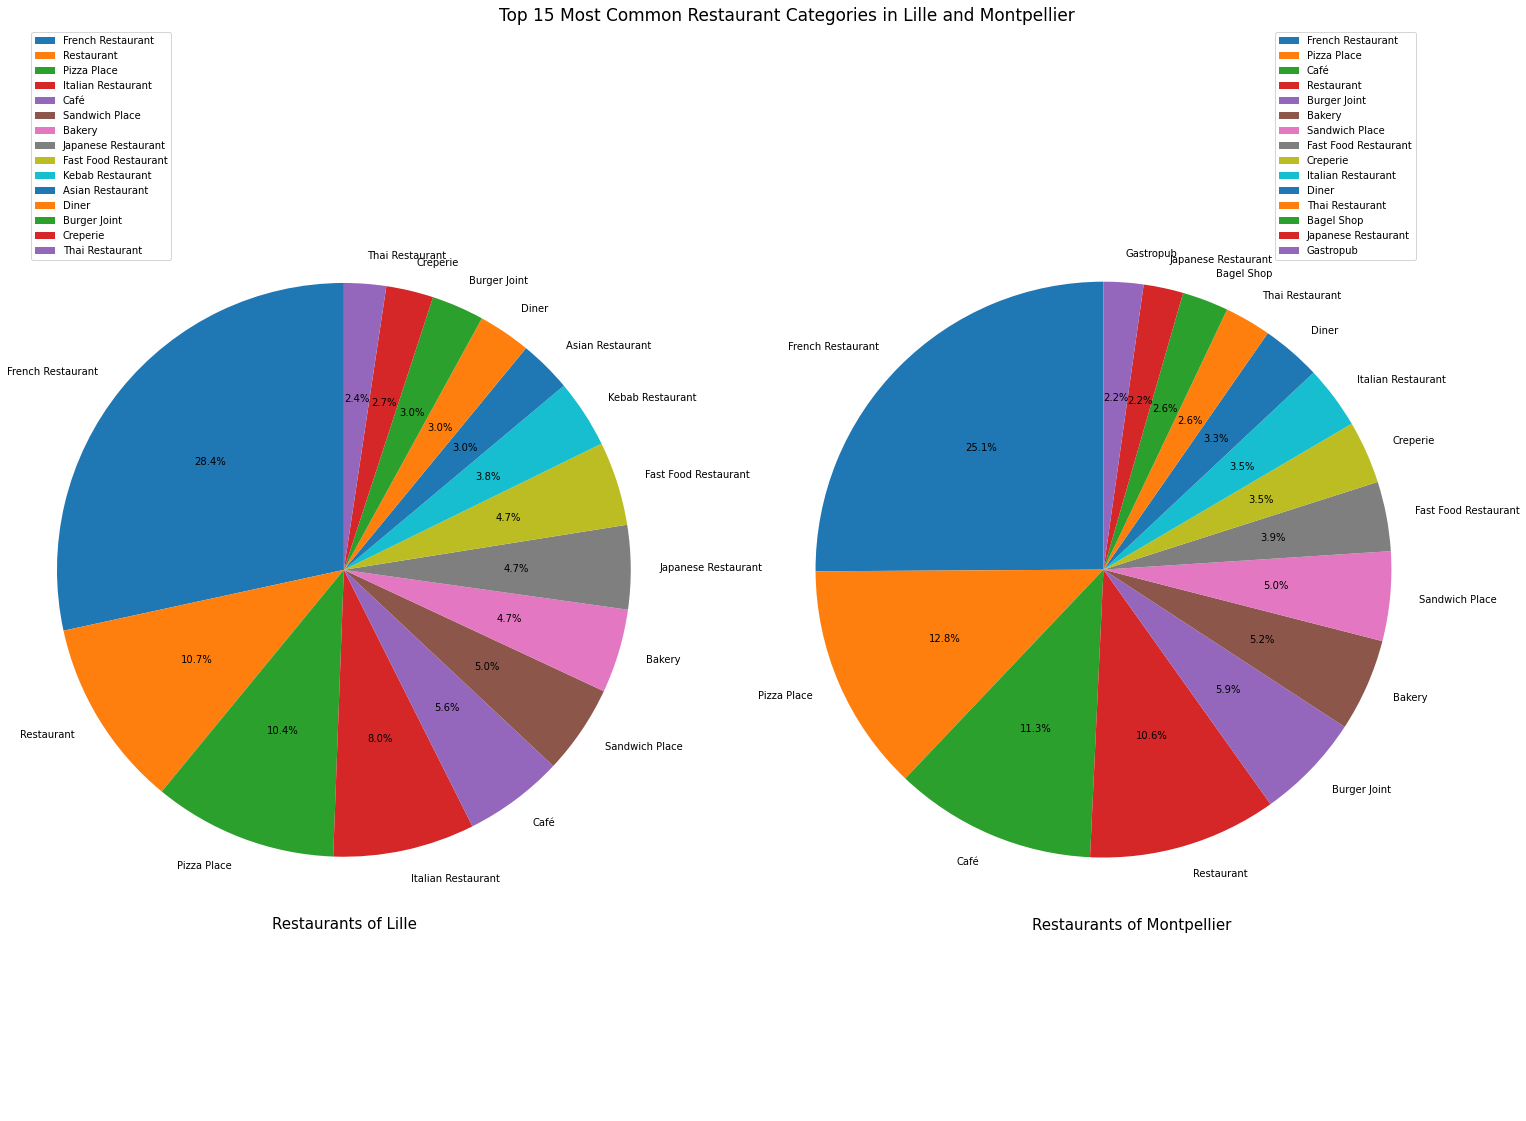

In [36]:
fig = plt.figure(figsize=(25, 20)) # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
Lille_Freq[:15].plot(kind='pie', ax=ax0, subplots=True, autopct='%1.1f%%',
                            startangle=90,    
                            ) # add to subplot 1

ax0.text(-0.25,-1.25, "Restaurants of Lille",size=15)
ax0.set_ylabel('')
ax0.axis('equal') 
ax0.legend(loc='upper left')

# Subplot 2: Line plot
Montpellier_Freq[:15].plot(kind='pie', figsize=(30, 20), ax=ax1, subplots=True,autopct='%1.1f%%',
                            startangle=90,) # add to subplot 2

ax1.set_ylabel('')
ax1.text(-0.25,-1.25, "Restaurants of Montpellier",size=15)

ax1.axis('equal')

plt.title('Top 15 Most Common Restaurant Categories in Lille and Montpellier', y=1, x=0, size=17)
plt.show()

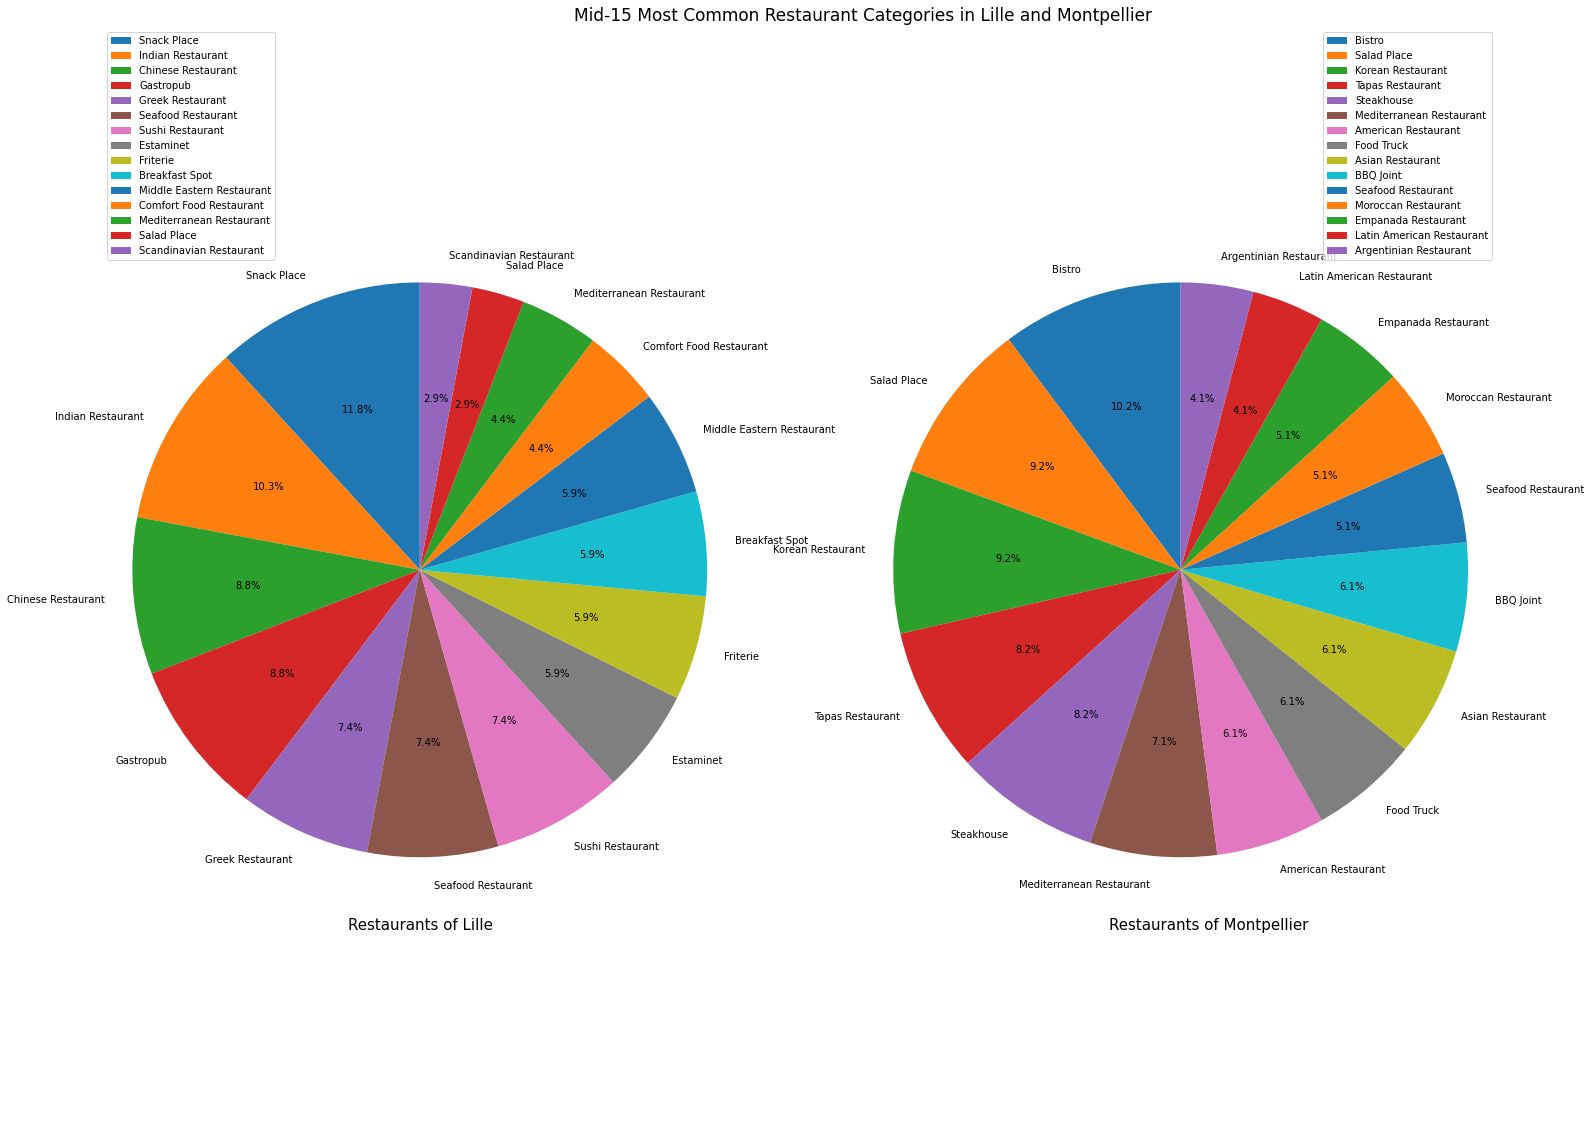

In [37]:
fig = plt.figure(figsize=(25, 20)) # create figure

ax2 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax3 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
Lille_Freq[15:30].plot(kind='pie', ax=ax2, subplots=True, autopct='%1.1f%%',
                            startangle=90,    
                            ) # add to subplot 1

ax2.text(-0.25,-1.25, "Restaurants of Lille",size=15)
ax2.set_ylabel('')
ax2.axis('equal') 
ax2.legend(loc='upper left')

# Subplot 2: Line plot
Montpellier_Freq[15:30].plot(kind='pie', figsize=(30, 20), ax=ax3, subplots=True,autopct='%1.1f%%',
                            startangle=90,) # add to subplot 2

ax3.set_ylabel('')
ax3.text(-0.25,-1.25, "Restaurants of Montpellier",size=15)
ax3.axis('equal')

plt.title('Mid-15 Most Common Restaurant Categories in Lille and Montpellier', y=1, x=0, size=17)
plt.show()

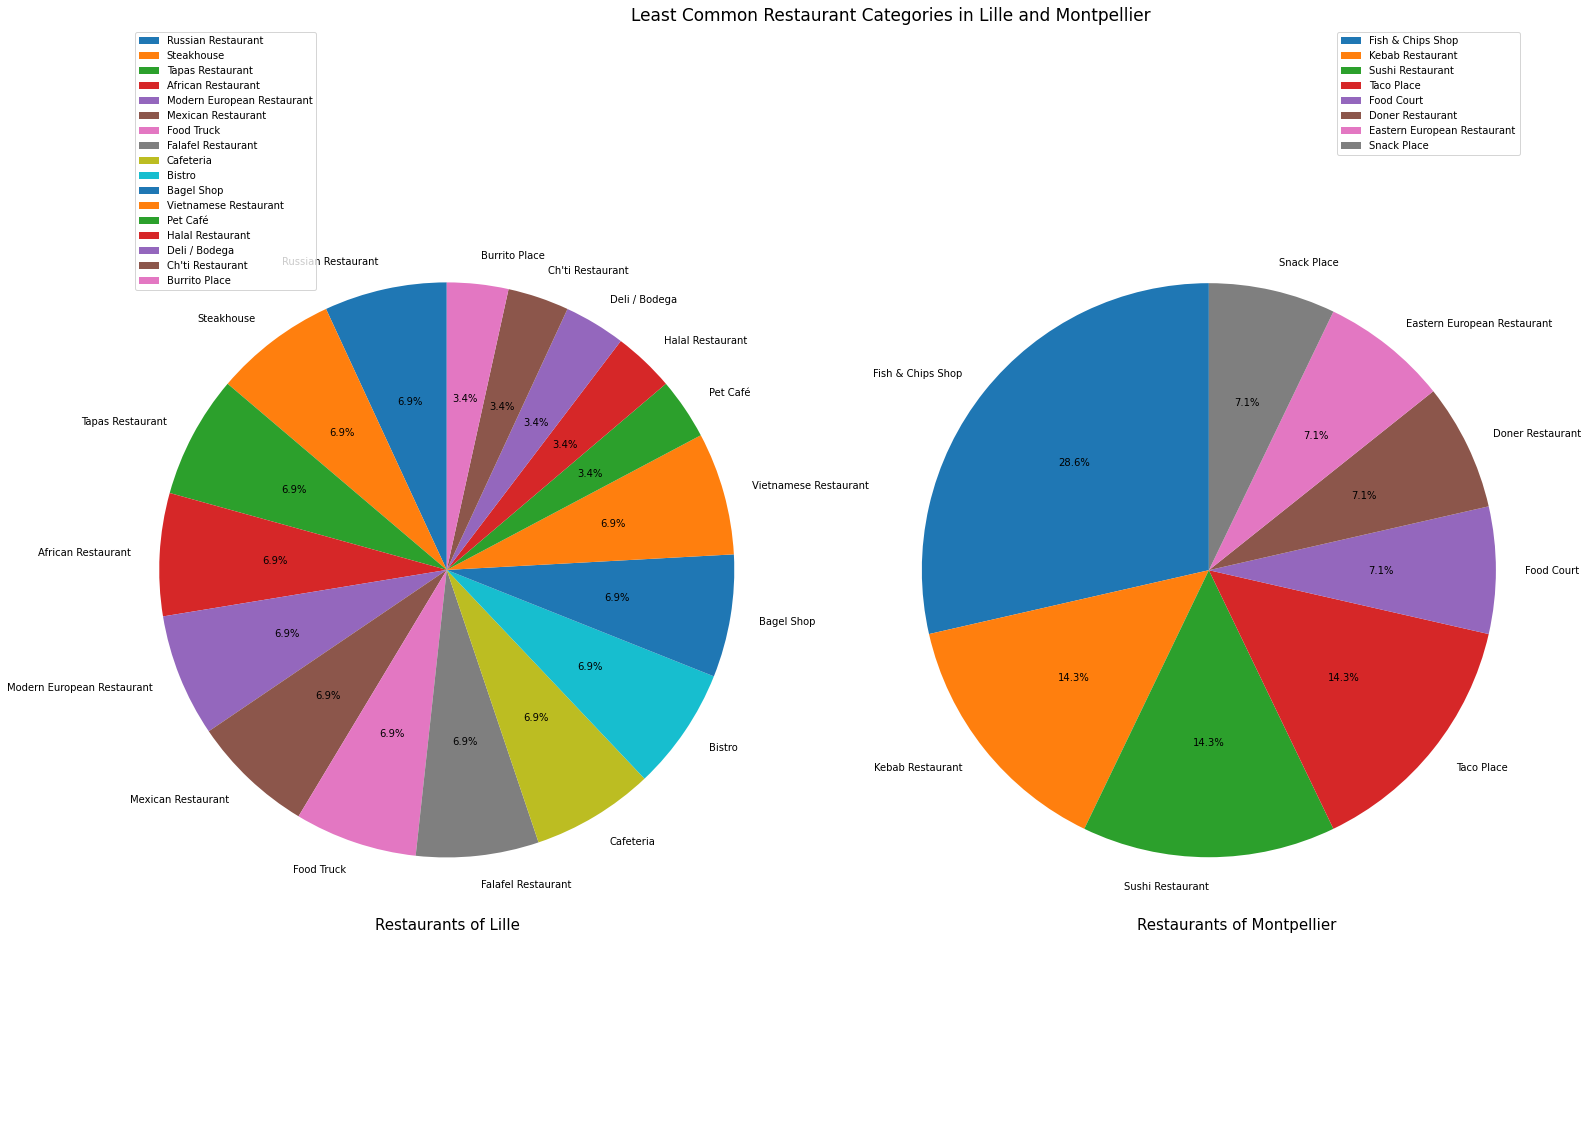

In [38]:
fig = plt.figure(figsize=(25, 20)) # create figure

ax4 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax5 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
Lille_Freq[30:47].plot(kind='pie', ax=ax4, subplots=True, autopct='%1.1f%%',
                            startangle=90,    
                            ) # add to subplot 1

ax4.text(-0.25,-1.25, "Restaurants of Lille",size=15)
ax4.set_ylabel('')
ax4.axis('equal') 
ax4.legend(loc='upper left')

# Subplot 2: Line plot
Montpellier_Freq[30:45].plot(kind='pie', figsize=(30, 20), ax=ax5, subplots=True,autopct='%1.1f%%',
                            startangle=90,) # add to subplot 2

ax5.set_ylabel('')
ax5.text(-0.25,-1.25, "Restaurants of Montpellier",size=15)
ax5.axis('equal')

plt.title('Least Common Restaurant Categories in Lille and Montpellier', y=1, x=0, size=17)
plt.show()

# Clustering of Neighborhoods

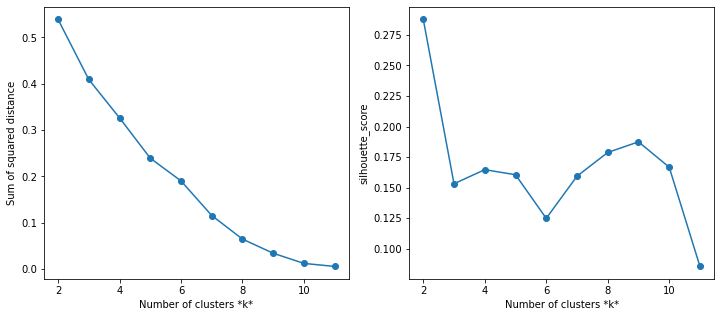

In [39]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

sse = []
sscr =[]
list_k = list(range(2, 12))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0).fit(Lille_grouped.drop('Neighborhood', 1))
    sse.append(km.inertia_)
    sscr.append(silhouette_score(Lille_grouped.drop('Neighborhood', 1), km.labels_, metric='euclidean'))

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.subplot(122)
plt.plot(list_k, sscr, '-o',label='silhouette_score')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('silhouette_score');

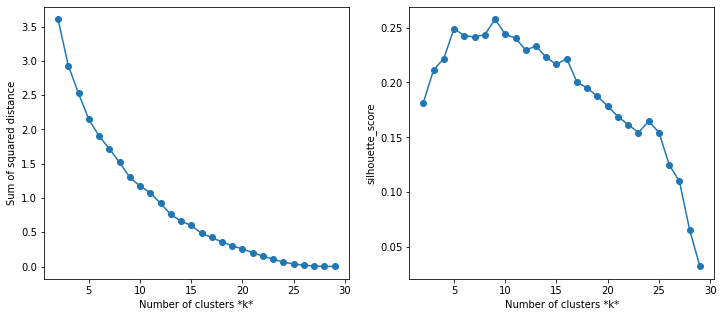

In [40]:
sse = []
sscr =[]
list_k = list(range(2, 30))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0).fit(Montpellier_grouped.drop('Neighborhood', 1))
    sse.append(km.inertia_)
    sscr.append(silhouette_score(Montpellier_grouped.drop('Neighborhood', 1), km.labels_, metric='euclidean'))

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.subplot(122)
plt.plot(list_k, sscr, '-o',label='silhouette_score')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('silhouette_score');

In [41]:
# set number of clusters
kclusters = 3

Lille_grouped_clustering = Lille_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Lille_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 1, 0, 1, 2, 2, 1, 0], dtype=int32)

In [42]:
# set number of clusters
kclusters = 10

Montpellier_grouped_clustering = Montpellier_grouped.drop('Neighborhood', 1)

# run k-means clustering
MTP_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Montpellier_grouped_clustering)

# check cluster labels generated for each row in the dataframe
MTP_kmeans.labels_[0:10] 

array([5, 3, 5, 0, 7, 8, 0, 0, 3, 2], dtype=int32)

In [43]:
# add clustering labels
Lille_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Lille_merged = Lille_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Lille_merged = Lille_merged.join(Lille_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Lille_merged.head() # check the last columns!

,Commune,Neighborhood,Postal Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lille,Lille-Moulins,59000,50.619097,3.070176,1,Pizza Place,French Restaurant,Gastropub,Diner,Friterie,Thai Restaurant,Italian Restaurant,Kebab Restaurant,Mediterranean Restaurant,Café
1,Lille,Faubourg de Béthune,59000,50.618164,3.033288,0,Italian Restaurant,Fast Food Restaurant,Burger Joint,Restaurant,Pizza Place,French Restaurant,Modern European Restaurant,Vietnamese Restaurant,Chinese Restaurant,Falafel Restaurant
2,Lomme,Lomme,59160,50.642422,2.994238,2,Restaurant,French Restaurant,Halal Restaurant,Bakery,Chinese Restaurant,Food Truck,Fast Food Restaurant,Falafel Restaurant,Estaminet,Diner
3,Lille,Bois-Blancs,59000,50.631116,3.027952,1,Sandwich Place,Restaurant,Pizza Place,Snack Place,Food Truck,Bakery,Italian Restaurant,Gastropub,Middle Eastern Restaurant,French Restaurant
4,Hellemmes,Hellemmes,59260,50.625727,3.109710,1,Kebab Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Comfort Food Restaurant,French Restaurant,Vietnamese Restaurant,Chinese Restaurant,Fast Food Restaurant,Falafel Restaurant


In [44]:
Lille_merged.sort_values(by='Cluster Labels', axis=0, ascending=True).drop(['Commune', 'Latitude', 'Longitude','Postal Code'], axis=1)

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Faubourg de Béthune,0,Italian Restaurant,Fast Food Restaurant,Burger Joint,Restaurant,Pizza Place,French Restaurant,Modern European Restaurant,Vietnamese Restaurant,Chinese Restaurant,Falafel Restaurant
5,Vauban-Esquermes,0,French Restaurant,Kebab Restaurant,Café,Pizza Place,Restaurant,Fast Food Restaurant,Italian Restaurant,Greek Restaurant,Sandwich Place,Bakery
7,Lille-Centre,0,French Restaurant,Restaurant,Café,Italian Restaurant,Japanese Restaurant,Burger Joint,Fast Food Restaurant,Bakery,Creperie,Diner
8,Wazemmes,0,French Restaurant,Pizza Place,Restaurant,Japanese Restaurant,Café,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Bakery,Kebab Restaurant
10,Vieux-Lille,0,French Restaurant,Restaurant,Creperie,Italian Restaurant,Japanese Restaurant,Café,Pizza Place,Burger Joint,Seafood Restaurant,Asian Restaurant
0,Lille-Moulins,1,Pizza Place,French Restaurant,Gastropub,Diner,Friterie,Thai Restaurant,Italian Restaurant,Kebab Restaurant,Mediterranean Restaurant,Café
3,Bois-Blancs,1,Sandwich Place,Restaurant,Pizza Place,Snack Place,Food Truck,Bakery,Italian Restaurant,Gastropub,Middle Eastern Restaurant,French Restaurant
4,Hellemmes,1,Kebab Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Comfort Food Restaurant,French Restaurant,Vietnamese Restaurant,Chinese Restaurant,Fast Food Restaurant,Falafel Restaurant
6,Saint-Maurice Pellevoisin,1,Pizza Place,Italian Restaurant,Restaurant,Gastropub,Salad Place,French Restaurant,Friterie,Japanese Restaurant,Fast Food Restaurant,Sandwich Place
11,Fives,1,Cafeteria,Sandwich Place,Friterie,Diner,Deli / Bodega,Italian Restaurant,Kebab Restaurant,Pizza Place,French Restaurant,Sushi Restaurant


In [45]:
# add clustering labels
Montpellier_venues_sorted.insert(0, 'Cluster Labels', MTP_kmeans.labels_)

Montpellier_merged = MTP_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Montpellier_merged = Montpellier_merged.join(Montpellier_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Montpellier_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Postal Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Plan des 4 Seigneurs,43.6375,3.8528,34090,4,French Restaurant,Bakery,Salad Place,Restaurant,Creperie,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Doner Restaurant
1,Hopitaux-Facultés,43.6329,3.8477,34090,7,Pizza Place,Japanese Restaurant,Salad Place,Burger Joint,Café,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Doner Restaurant,Diner
2,Aiguelongue,43.6287,3.8831,34090,5,Restaurant,Pizza Place,Fast Food Restaurant,Salad Place,Burger Joint,Empanada Restaurant,Eastern European Restaurant,Doner Restaurant,Diner,Creperie
3,Les Hauts de Massane,43.6387,3.8172,34080,7,Pizza Place,BBQ Joint,Bakery,Sandwich Place,Diner,Creperie,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant
4,Alco,43.6235,3.8426,34080,5,Pizza Place,Fast Food Restaurant,Salad Place,Restaurant,Burger Joint,Empanada Restaurant,Eastern European Restaurant,Doner Restaurant,Diner,Creperie


In [46]:
Montpellier_merged.sort_values(by='Cluster Labels', axis=0, ascending=True).drop(['Latitude', 'Longitude','Postal Code'], axis=1).head(15)

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Centre Historique,0,French Restaurant,Café,Pizza Place,Restaurant,Burger Joint,Creperie,Sandwich Place,Bagel Shop,Gastropub,Italian Restaurant
14,Les Arceaux,0,French Restaurant,Bakery,Diner,Café,Food Truck,Restaurant,Pizza Place,Bistro,Burger Joint,Bagel Shop
19,Port Marianne,0,French Restaurant,Sandwich Place,Bakery,Italian Restaurant,Japanese Restaurant,Food Truck,Steakhouse,Bagel Shop,Restaurant,Pizza Place
21,Gambetta,0,French Restaurant,Café,Pizza Place,Restaurant,Burger Joint,Creperie,Sandwich Place,Korean Restaurant,Bagel Shop,Bistro
11,Millénaire,0,French Restaurant,Bakery,Sandwich Place,Fast Food Restaurant,Japanese Restaurant,Café,Restaurant,Pizza Place,Diner,Italian Restaurant
10,La Pompignane,0,French Restaurant,Bakery,Italian Restaurant,Pizza Place,Steakhouse,Taco Place,Restaurant,Café,Empanada Restaurant,Eastern European Restaurant
9,Les Beaux - Arts,0,French Restaurant,Pizza Place,Restaurant,Salad Place,Thai Restaurant,Snack Place,Fish & Chips Shop,Argentinian Restaurant,Asian Restaurant,BBQ Joint
17,Comédie,0,French Restaurant,Café,Pizza Place,Restaurant,Burger Joint,Creperie,Sandwich Place,Bagel Shop,Gastropub,Italian Restaurant
16,Antigone,0,French Restaurant,Café,Restaurant,Pizza Place,Burger Joint,Creperie,Sandwich Place,Italian Restaurant,Bakery,Gastropub
23,Gares,0,French Restaurant,Café,Burger Joint,Restaurant,Pizza Place,Sandwich Place,Bagel Shop,Creperie,Korean Restaurant,Bistro


In [47]:
##### create map
map_clusters = folium.Map(location=[latitude_Lille, longitude_Lille], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Lille_merged['Latitude'], Lille_merged['Longitude'], Lille_merged['Neighborhood'], Lille_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [48]:
# create map
map_clusters = folium.Map(location=[latitude_MTP, longitude_MTP], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Montpellier_merged['Latitude'], Montpellier_merged['Longitude'], Montpellier_merged['Neighborhood'], Montpellier_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Individual Clusters for Lille

In [49]:
Lille_merged.loc[Lille_merged['Cluster Labels'] == 0, Lille_merged.columns[[1] + list(range(5, Lille_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Faubourg de Béthune,0,Italian Restaurant,Fast Food Restaurant,Burger Joint,Restaurant,Pizza Place,French Restaurant,Modern European Restaurant,Vietnamese Restaurant,Chinese Restaurant,Falafel Restaurant
5,Vauban-Esquermes,0,French Restaurant,Kebab Restaurant,Café,Pizza Place,Restaurant,Fast Food Restaurant,Italian Restaurant,Greek Restaurant,Sandwich Place,Bakery
7,Lille-Centre,0,French Restaurant,Restaurant,Café,Italian Restaurant,Japanese Restaurant,Burger Joint,Fast Food Restaurant,Bakery,Creperie,Diner
8,Wazemmes,0,French Restaurant,Pizza Place,Restaurant,Japanese Restaurant,Café,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Bakery,Kebab Restaurant
10,Vieux-Lille,0,French Restaurant,Restaurant,Creperie,Italian Restaurant,Japanese Restaurant,Café,Pizza Place,Burger Joint,Seafood Restaurant,Asian Restaurant


In [50]:
Lille_merged.loc[Lille_merged['Cluster Labels'] == 1, Lille_merged.columns[[1] + list(range(5, Lille_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lille-Moulins,1,Pizza Place,French Restaurant,Gastropub,Diner,Friterie,Thai Restaurant,Italian Restaurant,Kebab Restaurant,Mediterranean Restaurant,Café
3,Bois-Blancs,1,Sandwich Place,Restaurant,Pizza Place,Snack Place,Food Truck,Bakery,Italian Restaurant,Gastropub,Middle Eastern Restaurant,French Restaurant
4,Hellemmes,1,Kebab Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Comfort Food Restaurant,French Restaurant,Vietnamese Restaurant,Chinese Restaurant,Fast Food Restaurant,Falafel Restaurant
6,Saint-Maurice Pellevoisin,1,Pizza Place,Italian Restaurant,Restaurant,Gastropub,Salad Place,French Restaurant,Friterie,Japanese Restaurant,Fast Food Restaurant,Sandwich Place
11,Fives,1,Cafeteria,Sandwich Place,Friterie,Diner,Deli / Bodega,Italian Restaurant,Kebab Restaurant,Pizza Place,French Restaurant,Sushi Restaurant


In [51]:
Lille_merged.loc[Lille_merged['Cluster Labels'] == 2, Lille_merged.columns[[1] + list(range(5, Lille_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Lomme,2,Restaurant,French Restaurant,Halal Restaurant,Bakery,Chinese Restaurant,Food Truck,Fast Food Restaurant,Falafel Restaurant,Estaminet,Diner
9,Lille-Sud,2,Restaurant,Pizza Place,Café,Sandwich Place,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Estaminet,Diner,Deli / Bodega


In [52]:
Lille_merged.loc[Lille_merged['Cluster Labels'] == 3, Lille_merged.columns[[1] + list(range(5, Lille_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


Individual Clusters for Montpellier

In [53]:
Montpellier_merged.loc[Montpellier_merged['Cluster Labels'] == 0, Montpellier_merged.columns[[0] + list(range(5, Montpellier_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Mosson,French Restaurant,Burger Joint,Restaurant,Pizza Place,BBQ Joint,Bagel Shop,Bakery,Bistro,Asian Restaurant,Argentinian Restaurant
7,Les Aubes,French Restaurant,Pizza Place,Food Truck,Japanese Restaurant,Thai Restaurant,Taco Place,Snack Place,Café,Empanada Restaurant,Eastern European Restaurant
9,Les Beaux - Arts,French Restaurant,Pizza Place,Restaurant,Salad Place,Thai Restaurant,Snack Place,Fish & Chips Shop,Argentinian Restaurant,Asian Restaurant,BBQ Joint
10,La Pompignane,French Restaurant,Bakery,Italian Restaurant,Pizza Place,Steakhouse,Taco Place,Restaurant,Café,Empanada Restaurant,Eastern European Restaurant
11,Millénaire,French Restaurant,Bakery,Sandwich Place,Fast Food Restaurant,Japanese Restaurant,Café,Restaurant,Pizza Place,Diner,Italian Restaurant
14,Les Arceaux,French Restaurant,Bakery,Diner,Café,Food Truck,Restaurant,Pizza Place,Bistro,Burger Joint,Bagel Shop
15,Centre Historique,French Restaurant,Café,Pizza Place,Restaurant,Burger Joint,Creperie,Sandwich Place,Bagel Shop,Gastropub,Italian Restaurant
16,Antigone,French Restaurant,Café,Restaurant,Pizza Place,Burger Joint,Creperie,Sandwich Place,Italian Restaurant,Bakery,Gastropub
17,Comédie,French Restaurant,Café,Pizza Place,Restaurant,Burger Joint,Creperie,Sandwich Place,Bagel Shop,Gastropub,Italian Restaurant
19,Port Marianne,French Restaurant,Sandwich Place,Bakery,Italian Restaurant,Japanese Restaurant,Food Truck,Steakhouse,Bagel Shop,Restaurant,Pizza Place


In [54]:
Montpellier_merged.loc[Montpellier_merged['Cluster Labels'] == 1, Montpellier_merged.columns[[0] + list(range(5, Montpellier_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Pas du Loup,Bakery,Bistro,Thai Restaurant,Diner,Food Court,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Doner Restaurant


In [55]:
Montpellier_merged.loc[Montpellier_merged['Cluster Labels'] == 2, Montpellier_merged.columns[[0] + list(range(5, Montpellier_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Figuerolles,Café,Restaurant,Pizza Place,Food Truck,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Doner Restaurant,Diner
24,Estanove,Pizza Place,Bakery,Bistro,Restaurant,Café,Creperie,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant
27,Lemasson,Pizza Place,Restaurant,Café,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Doner Restaurant,Diner,Creperie


In [56]:
Montpellier_merged.loc[Montpellier_merged['Cluster Labels'] == 3, Montpellier_merged.columns[[0] + list(range(5, Montpellier_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Aiguerelles,Fast Food Restaurant,Sandwich Place,Café,Diner,Sushi Restaurant,BBQ Joint,Bagel Shop,Japanese Restaurant,Food Court,Mediterranean Restaurant
29,Croix d'Argent,Fast Food Restaurant,Pizza Place,Eastern European Restaurant,Bakery,Salad Place,Café,Fish & Chips Shop,Empanada Restaurant,Doner Restaurant,Diner
30,Près d'Arènes,Fast Food Restaurant,French Restaurant,Bakery,Café,Restaurant,BBQ Joint,Bagel Shop,Bistro,Burger Joint,Food Truck


In [57]:
Montpellier_merged.loc[Montpellier_merged['Cluster Labels'] == 4, Montpellier_merged.columns[[0] + list(range(5, Montpellier_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Plan des 4 Seigneurs,French Restaurant,Bakery,Salad Place,Restaurant,Creperie,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Doner Restaurant


In [58]:
Montpellier_merged.loc[Montpellier_merged['Cluster Labels'] == 7, Montpellier_merged.columns[[0] + list(range(5, Montpellier_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Hopitaux-Facultés,Pizza Place,Japanese Restaurant,Salad Place,Burger Joint,Café,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Doner Restaurant,Diner
3,Les Hauts de Massane,Pizza Place,BBQ Joint,Bakery,Sandwich Place,Diner,Creperie,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant
8,Boutonnet,Pizza Place,Bakery,Fast Food Restaurant,Japanese Restaurant,Diner,Restaurant,French Restaurant,Bistro,Burger Joint,Bagel Shop
12,Les Cevennes,Pizza Place,French Restaurant,Bakery,Burger Joint,Diner,Creperie,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant
20,La Chamberte,Pizza Place,Café,Bakery,Burger Joint,Diner,Creperie,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant


In [59]:
Montpellier_merged.loc[Montpellier_merged['Cluster Labels'] == 8, Montpellier_merged.columns[[0] + list(range(5, Montpellier_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Celleneuve,Restaurant,BBQ Joint,Bakery,Burger Joint,Doner Restaurant,Creperie,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant


In [60]:
Montpellier_merged.loc[Montpellier_merged['Cluster Labels'] == 9, Montpellier_merged.columns[[0] + list(range(5, Montpellier_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Grammont,French Restaurant,Restaurant,Argentinian Restaurant,Creperie,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Doner Restaurant,Diner
